In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/home/suriya/dcu/Group-Project


In [4]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from src.datapoint import read_non_sensor_data

In [5]:
train_data_dir = 'data/tc4tl_training_data_v1/tc4tl/data/train/'
train_key = pd.read_csv('data/tc4tl_training_data_v1/tc4tl/docs/tc4tl_train_key.tsv', sep='\t')

In [45]:
def distance_from_rssi(rssi, TX, N):
    return np.power(10, (TX - rssi) / (10 * N))

distance_from_rssi(-51, -54, 2.1)

0.719685673001152

In [48]:
def cohort_2020_winning_sol_features(filepath, coarse_grained):
    filedump = open(filepath).read()
    ns = read_non_sensor_data(filedump)
    mean_rssi = np.array([ float(line.split(',')[-1])
                          for line in filedump.split('\n')
                          if 'Bluetooth' in line ]).mean()
    pla = float(ns['TXPower']) - 41 - mean_rssi
    pred_distance = distance_from_rssi(mean_rssi,
                                      TX=-52 if coarse_grained=='Y' else -54,
                                      N=2.6 if coarse_grained=='Y'  else 2.1)
    ns.update({
        'PathLossAttenuation' : pla,
        'MeanRssi' : mean_rssi,
        'CoarseGrained' : coarse_grained,
        'PredictedDistance' : pred_distance
    })
    return ns

In [49]:
filepath = os.path.join(train_data_dir, 'aajxgoxc_tc4tl20.csv')
cohort_2020_winning_sol_features(filepath, 'Y')

{'TXDevice': 'iPhone11',
 'TXPower': '8',
 'RXDevice': 'iPhone11',
 'TXCarry': 'pocket',
 'RXCarry': 'hand',
 'RXPose': 'standing',
 'TXPose': 'sitting',
 'PathLossAttenuation': 25.19147084421236,
 'MeanRssi': -58.19147084421236,
 'CoarseGrained': 'Y',
 'PredictedDistance': 1.7303481541669392}

In [50]:
features = []
for idx, row in tqdm(train_key.iterrows(), total=train_key.shape[0]):
    feat = cohort_2020_winning_sol_features(
        os.path.join(train_data_dir, row.fileid), row.coarse_grain)
    feat.update({
        'fileid' : row.fileid,
        'distance' : row.distance_in_meters
    })
    features.append(feat)

100%|██████████| 15552/15552 [00:15<00:00, 1027.42it/s]


In [59]:
trainframe = pd.DataFrame(features)
trainframe.to_csv('data/processed/2020_cohort_winning_sol.features.train.csv', index=False)
trainframe

,TXDevice,TXPower,RXDevice,TXCarry,RXCarry,RXPose,TXPose,PathLossAttenuation,MeanRssi,CoarseGrained,PredictedDistance,fileid,distance
0,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.133482,-62.133482,Y,2.453292,aaadbuvp_tc4tl20.csv,1.8
1,iPhone11,8,iPhoneXS,pocket,pocket,standing,standing,22.255556,-55.255556,N,1.147594,aaamkcii_tc4tl20.csv,3.0
2,iPhone6Plus,12,iPhone11,hand,hand,standing,standing,33.289089,-62.289089,N,2.481524,aabqtowt_tc4tl20.csv,1.2
3,iPhone7,12,iPhone11,pocket,pocket,sitting,sitting,38.938259,-67.938259,N,4.610273,aadkjwss_tc4tl20.csv,1.8
4,iPhone6s,12,iPhone8,hand,hand,standing,sitting,26.760797,-55.760797,Y,1.395231,aafzrgzt_tc4tl20.csv,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.998435,-62.998435,N,2.682236,zzwcoemu_tc4tl20.csv,1.2
15548,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,43.020677,-77.020677,N,12.480233,zzwoqxuc_tc4tl20.csv,4.5
15549,iPhoneXs_max,8,iPhoneXs_max,pocket,pocket,standing,sitting,41.469638,-74.469638,N,9.435060,zzymwbbb_tc4tl20.csv,1.2
15550,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,30.321346,-64.321346,Y,2.977816,zzzflikz_tc4tl20.csv,1.8


### Predicted Distance Stats

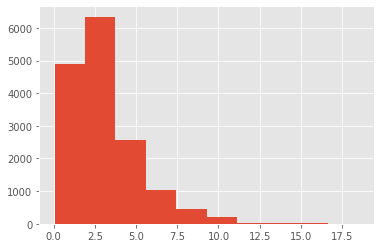

In [62]:
trainframe.PredictedDistance.hist();

In [63]:
trainframe.PredictedDistance.describe()

count    15552.000000
mean         3.132913
std          2.104072
min          0.050453
25%          1.674606
50%          2.614846
75%          3.926910
max         18.520465
Name: PredictedDistance, dtype: float64

## Min-Max Scaling

In [64]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

encoders = {
    'MeanRssi' : MinMaxScaler(),
    'PathLossAttenuation' : MinMaxScaler()
}

trainframe['NormMeanRssi'] = encoders['MeanRssi'].fit_transform(
                             trainframe['MeanRssi'].values.reshape(-1, 1)).reshape(-1)
trainframe['NormPathLossAttenuation'] = encoders['PathLossAttenuation'].fit_transform(
                                    trainframe['PathLossAttenuation'].values.reshape(-1, 1)).reshape(-1)

In [65]:
trainframe

,TXDevice,TXPower,RXDevice,TXCarry,RXCarry,RXPose,TXPose,PathLossAttenuation,MeanRssi,CoarseGrained,PredictedDistance,fileid,distance,NormMeanRssi,NormPathLossAttenuation
0,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.133482,-62.133482,Y,2.453292,aaadbuvp_tc4tl20.csv,1.8,0.343245,0.724865
1,iPhone11,8,iPhoneXS,pocket,pocket,standing,standing,22.255556,-55.255556,N,1.147594,aaamkcii_tc4tl20.csv,3.0,0.470944,0.524600
2,iPhone6Plus,12,iPhone11,hand,hand,standing,standing,33.289089,-62.289089,N,2.481524,aabqtowt_tc4tl20.csv,1.2,0.340356,0.727730
3,iPhone7,12,iPhone11,pocket,pocket,sitting,sitting,38.938259,-67.938259,N,4.610273,aadkjwss_tc4tl20.csv,1.8,0.235470,0.831733
4,iPhone6s,12,iPhone8,hand,hand,standing,sitting,26.760797,-55.760797,Y,1.395231,aafzrgzt_tc4tl20.csv,1.8,0.461564,0.607543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.998435,-62.998435,N,2.682236,zzwcoemu_tc4tl20.csv,1.2,0.327185,0.740789
15548,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,43.020677,-77.020677,N,12.480233,zzwoqxuc_tc4tl20.csv,4.5,0.066840,0.906891
15549,iPhoneXs_max,8,iPhoneXs_max,pocket,pocket,standing,sitting,41.469638,-74.469638,N,9.435060,zzymwbbb_tc4tl20.csv,1.2,0.114204,0.878336
15550,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,30.321346,-64.321346,Y,2.977816,zzzflikz_tc4tl20.csv,1.8,0.302623,0.673093


## Label Encoding

In [66]:
catcols = ['TXDevice', 'RXDevice', 'TXCarry', 'RXCarry', 'RXPose', 'TXPose', 'CoarseGrained']
encoders.update({
    col : LabelEncoder() for col in catcols
})
for col in catcols:
    trainframe[col + 'Enc'] = encoders[col].fit_transform(trainframe[col].values.reshape(-1, 1)).reshape(-1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [67]:
trainframe.to_csv('data/processed/2020_cohort_winning_sol.enc.features.train.csv', index=False)
trainframe

,TXDevice,TXPower,RXDevice,TXCarry,RXCarry,RXPose,TXPose,PathLossAttenuation,MeanRssi,CoarseGrained,...,distance,NormMeanRssi,NormPathLossAttenuation,TXDeviceEnc,RXDeviceEnc,TXCarryEnc,RXCarryEnc,RXPoseEnc,TXPoseEnc,CoarseGrainedEnc
0,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.133482,-62.133482,Y,...,1.8,0.343245,0.724865,11,4,1,0,1,1,1
1,iPhone11,8,iPhoneXS,pocket,pocket,standing,standing,22.255556,-55.255556,N,...,3.0,0.470944,0.524600,0,8,1,1,1,1,0
2,iPhone6Plus,12,iPhone11,hand,hand,standing,standing,33.289089,-62.289089,N,...,1.2,0.340356,0.727730,5,0,0,0,1,1,0
3,iPhone7,12,iPhone11,pocket,pocket,sitting,sitting,38.938259,-67.938259,N,...,1.8,0.235470,0.831733,7,0,1,1,0,0,0
4,iPhone6s,12,iPhone8,hand,hand,standing,sitting,26.760797,-55.760797,Y,...,1.8,0.461564,0.607543,6,4,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.998435,-62.998435,N,...,1.2,0.327185,0.740789,11,4,1,0,1,1,0
15548,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,43.020677,-77.020677,N,...,4.5,0.066840,0.906891,2,2,0,0,0,1,0
15549,iPhoneXs_max,8,iPhoneXs_max,pocket,pocket,standing,sitting,41.469638,-74.469638,N,...,1.2,0.114204,0.878336,14,9,1,1,1,0,0
15550,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,30.321346,-64.321346,Y,...,1.8,0.302623,0.673093,2,2,0,0,0,1,1


In [68]:
trainframe.columns

Index(['TXDevice', 'TXPower', 'RXDevice', 'TXCarry', 'RXCarry', 'RXPose',
       'TXPose', 'PathLossAttenuation', 'MeanRssi', 'CoarseGrained',
       'PredictedDistance', 'fileid', 'distance', 'NormMeanRssi',
       'NormPathLossAttenuation', 'TXDeviceEnc', 'RXDeviceEnc', 'TXCarryEnc',
       'RXCarryEnc', 'RXPoseEnc', 'TXPoseEnc', 'CoarseGrainedEnc'],
      dtype='object')

In [77]:
trainframe.distance = trainframe.distance.astype('str')

In [72]:
predictors = ['NormMeanRssi', 'NormPathLossAttenuation', 'PredictedDistance' ] + [ col + 'Enc' for col in catcols ]

## Correlation

In [86]:
import seaborn as sns

In [90]:
trainframe['DistanceContinuous'] = trainframe['distance'].astype('float')

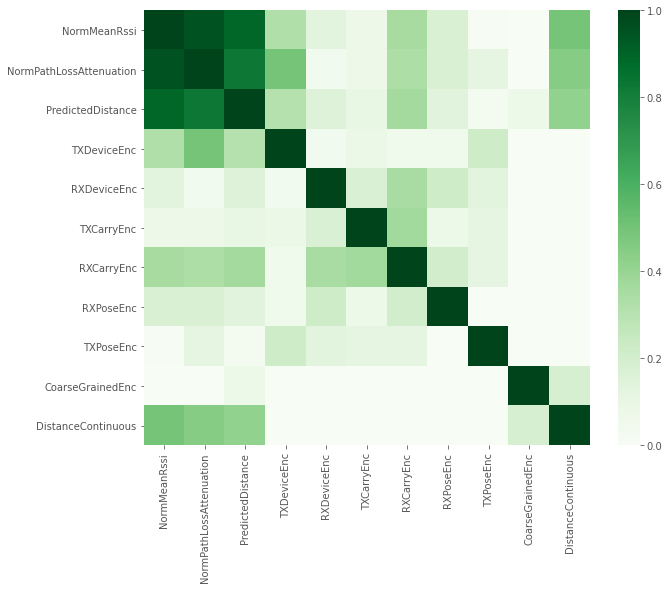

In [93]:
corr = trainframe[predictors + ['DistanceContinuous']].corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='Greens');

## Evaluation

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [81]:
X_train, X_test, y_train, y_test = train_test_split(trainframe[predictors], trainframe.distance, test_size=0.3, random_state=69)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [83]:
ypred = rf.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

         1.2       0.67      0.65      0.66       757
         1.8       0.71      0.71      0.71      1580
         3.0       0.50      0.53      0.51       758
         4.5       0.82      0.81      0.81      1571

    accuracy                           0.70      4666
   macro avg       0.67      0.67      0.67      4666
weighted avg       0.70      0.70      0.70      4666



### Gradient Boosting Machine 

In [97]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)

GradientBoostingClassifier()

In [98]:
ypred = gbm.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

         1.2       0.65      0.69      0.67       757
         1.8       0.67      0.71      0.69      1580
         3.0       0.45      0.40      0.42       758
         4.5       0.82      0.79      0.81      1571

    accuracy                           0.68      4666
   macro avg       0.65      0.65      0.65      4666
weighted avg       0.68      0.68      0.68      4666



## Evaluation on Test Set

In [12]:
from src.featutils import aggregate_features_from_folder
from src.features.t62020 import extract_features_from_file, postproc_feature_frame
from src.features.t62020 import PREDICTORS, TARGET

In [33]:
test_key = pd.read_csv('data/tc4tl_test_key/tc4tl/docs/tc4tl_test_key.tsv', sep='\t')
test_data_dir = 'data/tc4tl_data_v5/tc4tl/data/test/'
testset, testset_encoders = aggregate_features_from_folder(test_data_dir, test_key,
                               feat_fn=extract_features_from_file,
                               postproc_fn=postproc_feature_frame,
                               predictors=PREDICTORS, target=TARGET)

100%|██████████| 8423/8423 [00:13<00:00, 606.91it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [34]:
testset

,NormMeanRssi,NormPathLossAttenuation,PredictedDistance,TXDeviceEnc,RXDeviceEnc,TXCarryEnc,RXCarryEnc,RXPoseEnc,TXPoseEnc,CoarseGrainEnc,Distance
0,0.365054,0.586619,1.944310,0,1,0,0,0,0,0,4.5
1,0.345896,0.654104,2.313533,3,0,2,2,2,2,0,1.2
2,0.287217,0.712783,3.940482,3,0,1,1,1,1,0,4.5
3,0.399225,0.552448,1.425885,0,1,2,2,2,2,0,1.8
4,0.311400,0.688600,3.163983,3,0,2,2,2,2,0,1.2
...,...,...,...,...,...,...,...,...,...,...,...
8418,0.371796,0.567795,1.828907,1,4,2,2,2,2,0,1.2
8419,0.285545,0.714455,4.000734,3,0,0,1,1,1,0,3.0
8420,0.452590,0.499083,0.878523,0,1,2,2,2,2,0,1.2
8421,0.327977,0.672023,2.680334,3,0,2,2,2,2,1,1.8


## Fit on the whole training set

In [25]:
train_key = pd.read_csv('data/tc4tl_training_data_v1/tc4tl/docs/tc4tl_train_key.tsv', sep='\t')
train_data_dir = 'data/tc4tl_training_data_v1/tc4tl/data/train/'
trainset, trainset_encoders = aggregate_features_from_folder(train_data_dir, train_key,
                                                            feat_fn=extract_features_from_file,
                                                            postproc_fn=postproc_feature_frame,
                                                            predictors=PREDICTORS, target=TARGET)

100%|██████████| 15552/15552 [00:33<00:00, 462.90it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [26]:
trainset

,NormMeanRssi,NormPathLossAttenuation,PredictedDistance,TXDeviceEnc,RXDeviceEnc,TXCarryEnc,RXCarryEnc,RXPoseEnc,TXPoseEnc,CoarseGrainEnc,Distance
0,0.393624,0.674911,1.811751,12,5,0,0,1,0,0,1.8
1,0.442341,0.552962,1.529207,0,0,0,0,0,0,1,1.8
2,0.470384,0.525155,1.151395,0,8,1,1,1,1,0,1.8
3,0.183880,0.882888,6.252327,7,6,1,1,1,1,0,4.5
4,0.340600,0.727488,2.477940,13,7,1,0,1,1,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...
15547,0.161328,0.905250,7.143046,4,4,1,1,1,1,0,4.5
15548,0.198105,0.868783,4.902448,3,7,0,1,1,1,1,4.5
15549,0.438159,0.557109,1.560018,0,7,1,1,1,0,1,1.8
15550,0.198850,0.868044,5.723303,13,3,0,0,1,1,0,4.5


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [28]:
rf = RandomForestClassifier()
rf.fit(trainset[PREDICTORS], trainset[TARGET])
ypred = rf.predict(testset[PREDICTORS])

In [30]:
print(classification_report(testset[TARGET], ypred))

              precision    recall  f1-score   support

         1.2       0.47      0.52      0.50      1407
         1.8       0.54      0.57      0.55      2831
         3.0       0.29      0.25      0.27      1385
         4.5       0.61      0.57      0.59      2800

    accuracy                           0.51      8423
   macro avg       0.48      0.48      0.48      8423
weighted avg       0.51      0.51      0.51      8423



In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(testset[TARGET], ypred)

array([[ 737,  291,  262,  117],
       [ 574, 1606,  248,  403],
       [ 182,  337,  349,  517],
       [  64,  766,  362, 1608]])